In [1]:
%matplotlib inline

import logging

import matplotlib.pyplot as plt
import numpy as np

from dynrat import set_logging_level


# loggin levels include
#   'error'
#   'warning'
#   'info'
#   'debug'

set_logging_level('warning')

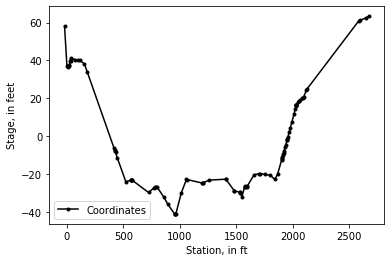

In [2]:
 from hydxscomp.crosssection import CrossSection
 
 from dynrat.sect import CrossSect


xs_csv = 'data/stlms/xs.csv'

roughness = 0.035
station, elevation = np.loadtxt(xs_csv, delimiter=',', skiprows=1, unpack=True)
datum = 379.58
elevation = elevation - datum
sect = CrossSect(CrossSection(station, elevation, roughness))

_ = sect.plot()

In [3]:
from dynrat.timeseries import read_nwis_csv


nwis_stage_csv = 'data/stlms/site_07010000_iv_q_s_NWIS.csv'
measured_stage, rated_flow = read_nwis_csv(nwis_stage_csv, interp_missing=True)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
_ = measured_stage.plot(ax1)
_ = rated_flow.plot(ax2)

measured_stage.null_obs()

ImportError: cannot import name 'read_nwis_csv' from 'dynrat.timeseries' (d:\source\dynamic_rating\dynrat\dynrat\timeseries.py)

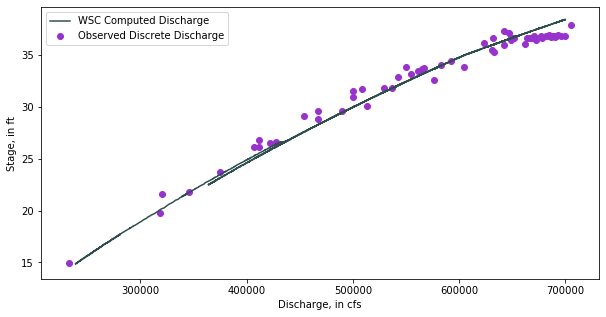

In [4]:
from dynrat.plot import stage_discharge_plot
from dynrat.timeseries import read_nwis_rdb


fm_rdb_path = 'data/stlms/site_07010000_fm_NWIS.txt'
observed_stage, observed_flow = read_nwis_rdb(fm_rdb_path)

fig, ax = plt.subplots(figsize=(10, 5))
_ = stage_discharge_plot(measured_stage, rated_flow, ax)
_ = stage_discharge_plot(observed_stage, observed_flow, ax)

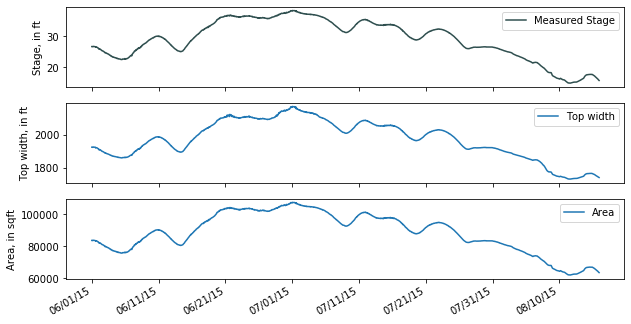

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 5))

_ = measured_stage.plot(ax1)

_ = measured_stage.cross_section_plot(sect, 'top width', ax=ax2)
_ = ax2.set_ylabel('Top width, in ft')
_ = ax2.set_xlabel('')

_ = measured_stage.cross_section_plot(sect, 'area', ax=ax3)
_ = ax3.set_ylabel('Area, in sqft')

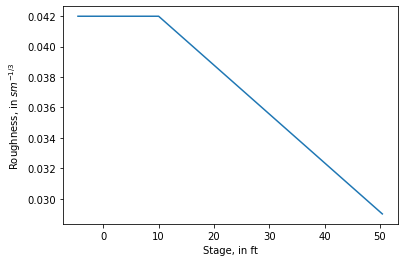

In [6]:
from dynrat.frict import TableFrict


stage = np.array([-4.58, 10, 50.42])
roughness = [0.042, 0.042, 0.029]

frict = TableFrict(stage, roughness)

_ = frict.plot()

In [7]:
from dynrat.rslope import r_slope


h_o = 4.68  # stage prior to start of typical flood
h_p = 24.18  # peak stage of typical flood
q_o = 129000  # flow prior to typical flood
q_p = 396000  # peak flow of typical flood
t_diff = 7.58  # elapsed time of stage rise to peak stage in days

bed_slope = 0.00011

slope_ratio = r_slope(h_o, h_p, q_o, q_p, bed_slope, sect, t_diff)
slope_ratio

20.576215943310306

In [8]:
from dynrat.dynmod import QSolver
from dynrat.solve import QTimeSeries


time_step = measured_stage.freq()

q_solver = QSolver(sect, frict, bed_slope, slope_ratio, time_step)

qts = QTimeSeries(q_solver)

q0 = rated_flow.values()[0]
computed_flow = qts.solve_ts(measured_stage, q0)

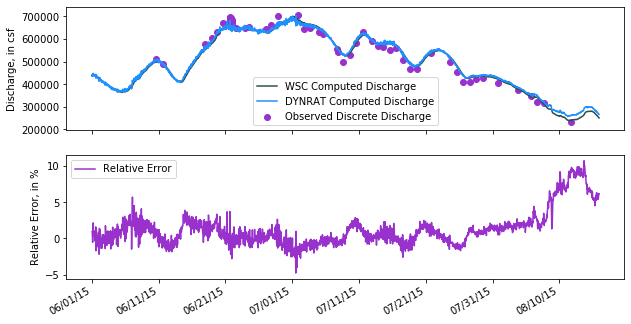

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

_ = rated_flow.plot(ax1)
_ = observed_flow.plot(ax1)
_ = computed_flow.plot(ax1)

_ = computed_flow.plot_relative_error(rated_flow, ax2)

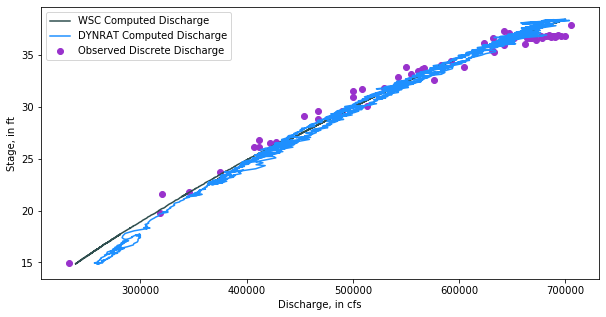

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = stage_discharge_plot(measured_stage, rated_flow, ax)
_ = stage_discharge_plot(observed_stage, observed_flow, ax)
_ = stage_discharge_plot(measured_stage, computed_flow, ax, color='dodgerblue', label='DYNRAT Computed Discharge')

In [11]:
computed_flow.rmse(rated_flow)

8862.584480063786

In [12]:
computed_flow.mean_error(rated_flow, relative=True)

1.2576300632495772